# Unimodal Fine Tuning before Multimodal Learning

In [1]:
import os, torch, torchvision, time, copy, timm
from skimage import transform
from __future__ import print_function, division
import torch.nn as nn, torch.optim as optim, matplotlib.pyplot as plt, numpy as np, pandas as pd, seaborn as sn
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms, utils 
from PIL import Image
from sklearn.metrics import confusion_matrix

device = 'cuda'
detection = 'head'

image_root = '/kaggle/input/source-fpus23/Dataset/four_poses'
datalink = {
    'train': '/kaggle/input/ultrasound-fpu23-csv-files/train_labels.csv',
    'valid': '/kaggle/input/ultrasound-fpu23-csv-files/val_labels.csv',
    'test' : '/kaggle/input/ultrasound-fpu23-csv-files/test_labels.csv'
}

def parameters_from_name(sub_dir):
    splitted_foldername = sub_dir.split("_")
    fetus_orientation = splitted_foldername[1]
    
    head_up = 0
    if fetus_orientation[:2] =='hu':
        head_up=1
    front_view = 0
    if fetus_orientation[2:] =='vf':
        front_view=1
        
    if splitted_foldername[2] =='aroundabd':
        location_organ = 0
    if splitted_foldername[2] =='aroundsbd': #There was a wrong folder name 'aroundsbd'
        location_organ = 0

    if splitted_foldername[2] =='longrec':
        location_organ = 1
    if splitted_foldername[2] =='aroundhead':
        location_organ = 2
    if splitted_foldername[2] =='aroundarms':
        location_organ = 3
    if splitted_foldername[2] =='aroundlegs':
        location_organ = 4
        
    invasive=1
    if splitted_foldername[3] =='h':
        invasive=0
        
    return head_up, front_view, location_organ, invasive

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

## Multimodal DataLoader

In [2]:
class MultimodalDataset(Dataset):
    # Modified from: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    def __init__(self, csv_file, root_dir, transform = None, detection = None):
        self.csv_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.detection = detection

    def __len__(self):
        return len(self.csv_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sub_dirs = self.csv_frame.iloc[idx, 0]
        img_name = self.root_dir + sub_dirs +'/' + self.csv_frame.iloc[idx, 1]
        image = Image.open(img_name)
        labels = self.csv_frame.iloc[idx, 3]
        
        if self.detection:
            detected = 0
            if self.detection in labels:
                detected = 1
            labels = detected

        other_inputs = parameters_from_name(sub_dirs)
        sample = {'image': image, 'information': other_inputs,'labels': labels}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

## Data Augmantation
Using existing transforms provided by Torchvision.

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((244,244)),
        transforms.RandomRotation(15,),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}

class MM_transform(object):
    def __init__(self, phase):
        assert isinstance(phase,(str))
        self.phase = phase
        
    def __call__(self, sample):
        image, information, labels = sample['image'],sample['information'], sample['labels']
        trnsfrm = data_transforms[self.phase]
        image = trnsfrm(image)
        
        return {'image': image, 'information': information, 'labels': labels}


## Dataloader with Custom Multimodal Transform

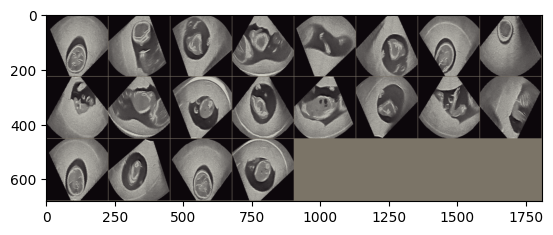

In [4]:
def dataset_phase(phase, detection):
    return MultimodalDataset(csv_file = datalink[phase], root_dir = image_root,
                        transform = MM_transform(phase), detection = detection)

def dataloader_phase(phase):
    return DataLoader(dataset[phase], batch_size=20, shuffle=True, num_workers=0)
    
dataset = {x: dataset_phase(x, detection) for x in ['train', 'valid', 'test']}
dataloaders = {x: dataloader_phase(x) for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(dataset[x]) for x in ['train', 'valid', 'test']}
               
sample_batch = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(sample_batch['image'])
imshow(out)#,title= [x for x in sample_batch['labels'] ])

## Pre-trained Models

In [5]:
Num_class = 2

model_ft = timm.create_model('vit_large_patch16_224', pretrained=True, num_classes=Num_class)
num_ftrs = model_ft.head.in_features
model_ft.head = nn.Linear(num_ftrs, Num_class)

#model_ft = models.resnet50(pretrained=True)
#num_ftrs = model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, Num_class)

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

## Unimodal Training Function

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    test_token=0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid', 'test']:
             
            
            '''
            Test when a better validation result is found
            '''
            if test_token ==0 and phase == 'test':
                continue
            test_token =0
            
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for sample_batch in dataloaders[phase]:
                inputs = sample_batch['image'].to(device)
                labels = sample_batch['labels'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                test_token =1


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## NN Training

In [7]:
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.4577 Acc: 0.8113
valid Loss: 0.2692 Acc: 0.8752
test Loss: 0.2674 Acc: 0.8742

Epoch 1/4
----------
train Loss: 0.2871 Acc: 0.8718
valid Loss: 0.2108 Acc: 0.8991
test Loss: 0.2067 Acc: 0.9063

Epoch 2/4
----------
train Loss: 0.2052 Acc: 0.9059
valid Loss: 0.1641 Acc: 0.9249
test Loss: 0.1611 Acc: 0.9245

Epoch 3/4
----------
train Loss: 0.1673 Acc: 0.9270
valid Loss: 0.1333 Acc: 0.9471
test Loss: 0.1279 Acc: 0.9474

Epoch 4/4
----------
train Loss: 0.1381 Acc: 0.9425
valid Loss: 0.0964 Acc: 0.9606
test Loss: 0.0909 Acc: 0.9643

Training complete in 71m 31s
Best val Acc: 0.960622


## Save Model

In [8]:
PATH = "./fine_tuned_model.pt"
torch.save(model_ft.state_dict(), PATH)

'''
#Guideline for loading model in future 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=False) 
        #We only need the structure to transfer parameters
        
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, Num_class)

model.load_state_dict(torch.load(PATH2, map_location=device))
'''

'\n#Guideline for loading model in future \ndevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")\nmodel = models.resnet50(pretrained=False) \n        #We only need the structure to transfer parameters\n        \nnum_ftrs = model.fc.in_features\nmodel.fc = nn.Linear(num_ftrs, Num_class)\n\nmodel.load_state_dict(torch.load(PATH2, map_location=device))\n'

## Confusion Matrix

Test Accuracy: 0.9642502482621649


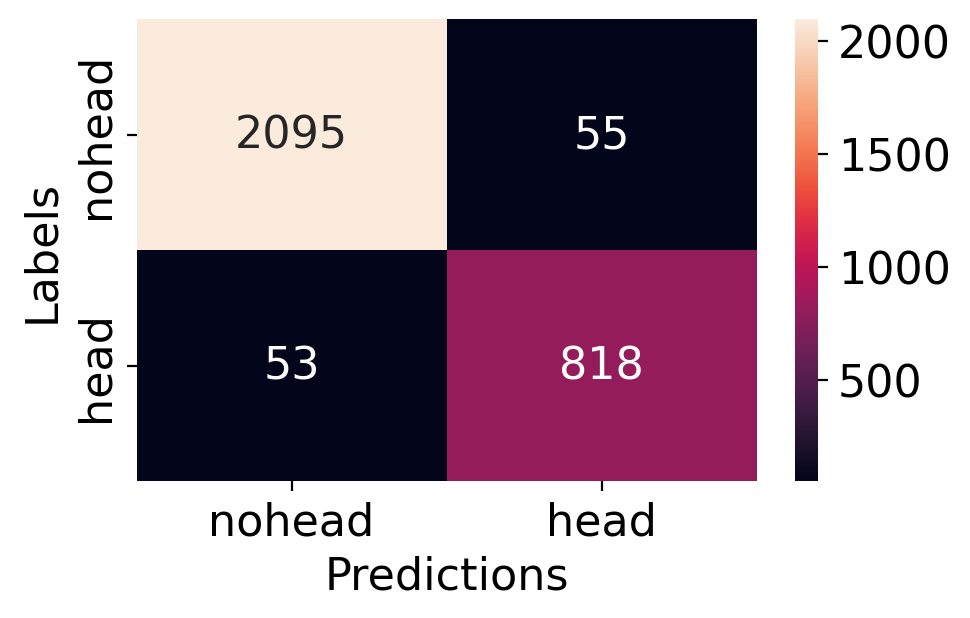

In [9]:
y_pred = []
y_true = []
output_all =[]

# iterate over test data
for sample_batch in dataloaders['test']:
        inputs = sample_batch['image'].to(device)
        labels = sample_batch['labels'].to(device)
        
        output = model_ft(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth


test_accuracy = 0
for iter1 in range(len(y_true)):
    if y_true[iter1] == y_pred[iter1]:
        test_accuracy = test_accuracy + 1

print('Test Accuracy:',test_accuracy/len(y_true))

        
# constant for classes
classes = ('no'+detection, detection)

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])



plt.figure(figsize = (5,3),dpi=200)
plt.rcParams['font.size'] = '16'
fig = sn.heatmap(df_cm, annot=True, fmt=".0f")
plt.ylabel("Labels")
plt.xlabel("Predictions")
plt.show(fig)

fig.figure.savefig('Confusion_test.pdf', bbox_inches = 'tight') 